In [165]:
import matplotlib
import matplotlib.pyplot as plt

def draw_chunks(ax, size = (10, 8), chunks = (2, 4)):
    nchunks = tuple(size[i] // chunks[i] for i in range(2))
    spacing = 0.1
    
    rsize = tuple((size[i] - spacing*(nchunks[i] + 1)) / nchunks[i] for i in range(2))
    
    for ii in range(nchunks[0]):
        for jj in range(nchunks[1]):
            box = matplotlib.patches.Rectangle((spacing + ii*(rsize[0] + spacing), spacing + jj*(rsize[1] + spacing)), rsize[0], rsize[1], 
                                               facecolor='wheat', edgecolor='black')
            
            ax.add_patch(box)
            
    ax.set_xbound(0, size[0])
    ax.set_ylim(0, size[1])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)
    

# Computations with large datasets

## General tools

### Python

 - [xarray](https://xarray.pydata.org) and [dask](https://docs.dask.org)
 - [multiprocessing.Pool](https://docs.python.org/3/library/multiprocessing.html#module-multiprocessing.pool)
 - [mpi4py](https://mpi4py.readthedocs.io/)

### Fortran/C

#### [mpi](https://en.wikipedia.org/wiki/Message_Passing_Interface)

MPI is a generic method of parallising to more than one computer, it's commonly used in HPC to enable programs running on different compute nodes to communicate.

MPI is a low-level library, which makes it flexible to a lot of use cases but also more difficult to set up. Numerical models often use MPI with a program running on each compute node computing part of the model grid, the boundaries between domains being syncronised with MPI messages.

##### Resources

 - [MPI function list](https://www.open-mpi.org/doc/current/)
 - [MPI standard](https://www.mpi-forum.org/docs/)

### Command-line tools

#### [cdo](https://code.mpimet.mpg.de/projects/cdo)

CDO has a large number of common climate analysis functions that can be used to analyse cf-compliant netcdf data.

##### Resources

 - `cdo --operators` will give a list of all available commands
 - `cdo --help COMMAND` will show detailed help

#### [nco](http://nco.sourceforge.net/)

NCO is a powerful tool for working with NetCDF files and metadata, though alongside that power it is also very complex to use. It can extract variables, modify attributes, change file chunking and compression and combine ensembles and timeseries alongside other functions.
 
### Other languages (Matlab, R, etc.)

While we're not aware of anything quite as nice as Xarray and Dask for other languages, most languages have libraries for reading NetCDF files and working with MPI.

If you have suggestions for other libraries we can list here please let us know by [opening a ticket](https://github.com/ACDguide/BigData/issues/new)

## Common Tasks

### Min / Max / Mean / Stddev

Functions like these are pretty simple to calculate regardless of dataset size, as they don't require the entire dataset to be in memory. You can just loop over the dimension to be reduced calculating value so far up to that step

In pseudocode (in Python you're better off using `data.min(axis=0)`, as that's optimised compared to a loop)

```python
for t in range(data.shape[0]):
    out_min = np.minimum(out_min, data[t,...])
    out_max = np.maximum(out_max, data[t,...])
    out_sum = out_sum + data[t,...]
    
out_mean = out_sum / data.shape[0]
```

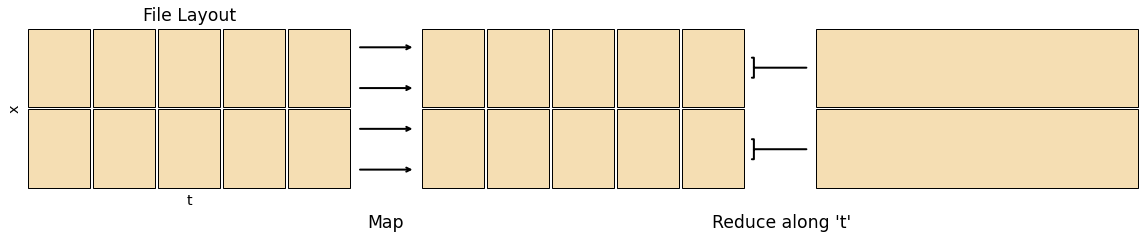

In [175]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(20,3))

draw_chunks(axs[0])
axs[0].set_xlabel('t', fontsize='x-large')
axs[0].set_ylabel('x', fontsize='x-large')
axs[0].set_title('File Layout', fontsize='xx-large')

draw_chunks(axs[1])

draw_chunks(axs[2], chunks=(10, 4))

for i in range(4):
    h = 1/4 * (i+0.5)
    conn = matplotlib.patches.ConnectionPatch((1.02, h), (-0.02, h), axs[0].transAxes, axs[1].transAxes, arrowstyle='->', linewidth=2)
    fig.add_artist(conn)

for i in range(2):
    h = 1/2 * (i+0.5)
    conn = matplotlib.patches.ConnectionPatch((1.02, h), (-0.02, h), axs[1].transAxes, axs[2].transAxes, arrowstyle=']-', linewidth=2)
    fig.add_artist(conn)
    
fig.add_artist(matplotlib.text.Text(0.375, -0.05, "Map", fontsize='xx-large',  ha='center', transform=fig.transFigure))
fig.add_artist(matplotlib.text.Text(0.65, -0.05, "Reduce along 't'", fontsize='xx-large',  ha='center', transform=fig.transFigure))

None

##### Resources

 - **Numpy** [statistics functions](https://numpy.org/doc/stable/reference/routines.statistics.html)
 - **Dask** also has optimised implementations for its arrays, e.g. [dask.array.mean](https://docs.dask.org/en/latest/array-api.html#dask.array.mean)
 - **Xarray** functions work the same as numpy, but keep the xarray metadata and you can use dimension names instead of axis numbers
 - **CDO** `cdo --operators | grep fld` will give a list of basic statistics operations

### Percentiles / Median

Percentiles are much trickier to calculate than basic statistics. To find the percentiles for a grid cell, you have to load the whole timeseries into memory, sort that timeseries, then find the value $N\%$ along that sorted timeseries. For a large dataset this becomes very costly, especially since most datasets are stored in a way optimised for loading the whole domain at a single time rather than the timeseries at a single point.

When there are `NAN` values in the timeseries percentiles become even harder to calculate, as the `NAN` values must be discarded by the algorithm.

There are approximate ways to compute percentiles that don't require the whole dataset in memory such as [T-digest](https://github.com/tdunning/t-digest)

Memory concerns are less of an issue when calculating percentiles on a subset of the data - e.g. when calculating climatologies.

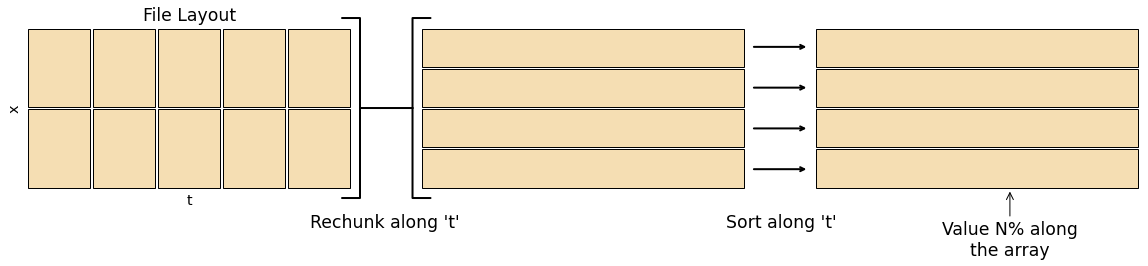

In [181]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(20,3))

draw_chunks(axs[0])
axs[0].set_xlabel('t', fontsize='x-large')
axs[0].set_ylabel('x', fontsize='x-large')
axs[0].set_title('File Layout', fontsize='xx-large')

draw_chunks(axs[1], chunks=(10, 2))

draw_chunks(axs[2], chunks=(10, 2))
axs[2].annotate('Value N% along\nthe array', (0.6, 0), (0.6, -0.4), 'axes fraction', 'axes fraction', fontsize='xx-large', arrowprops={'arrowstyle': '->'}, ha='center')

regrid_conn = matplotlib.patches.ConnectionPatch((1.02, 0.5), (-0.02, 0.5), axs[0].transAxes, axs[1].transAxes, arrowstyle=']-[', mutation_scale=90, linewidth=2)
fig.add_artist(regrid_conn)

for i in range(4):
    h = 1/4 * (i+0.5)
    sort_conn = matplotlib.patches.ConnectionPatch((1.02, h), (-0.02, h), axs[1].transAxes, axs[2].transAxes, arrowstyle='->', linewidth=2)
    fig.add_artist(sort_conn)
    
fig.add_artist(matplotlib.text.Text(0.375, -0.05, "Rechunk along 't'", fontsize='xx-large',  ha='center', transform=fig.transFigure))
fig.add_artist(matplotlib.text.Text(0.65, -0.05, "Sort along 't'", fontsize='xx-large',  ha='center', transform=fig.transFigure))

None

##### Resources

 - **Numpy** [percentile](https://numpy.org/doc/stable/reference/generated/numpy.percentile.html) and the more expensive [nanpercentile](https://numpy.org/doc/stable/reference/generated/numpy.nanpercentile.html)
 - **Dask** [percentile](https://docs.dask.org/en/latest/array-api.html#dask.array.percentile) uses approximate methods so is less memory intensive, but only works on 1D data
 - **Xarray** [quantile](xarray.pydata.org/en/stable/generated/xarray.Dataset.quantile.html) uses values between 0 and 1 instead of percents, dask data must not be chunked along the axis of interest
 - **CDO** `cdo --operators | grep pctl` will give a list of percentile related operations.

### Climatologies

### Time Resampling

### Horizontal Regridding

### Rolling Averages